---
# Alignment

An issue is that if your subject moves across runs, you will need to designate CSF and WM voxels separately for each run, because otherwise your acompcorr analysis will obviously pick up task-related signals because you’re sampling gray matter. That’s a danger you would want to expressly avoid. Hence, I now do the following:

1) For each run, manually align the runs to the first acquired slice. This slice is the closest to the low-resolution anatomy, so we can use this to transform our segmentations
2) Insert the list of transformations into `linescanning.Segmentations`, so that `call_antsapplytransforms` implements both transformations to warp the segmentations to each run separately

In [1]:
from linescanning import utils,prf,dataset,plotting, segmentations
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import sem
from statsmodels.api import stats
import os
opj = os.path.join

warnings.simplefilter('ignore')
project_dir     = os.environ.get("DIR_PROJECTS")
base_dir        = os.path.join(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox        = 359
plot_xkcd       = False
np.set_printoptions(precision=3)


/home/gjheij/anaconda3/envs/mpl/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/gjheij/anaconda3/envs/mpl/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
# Load data
sub         = '003'
ses         = 4
task        = "task-pRF"
run         = [2,5]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
anat_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "anat")
trafo_dir   = opj(base_dir, 'testing', 'alignment')
log_dir     = "/mnt/d/FSL/shared/spinoza/programs/project_repos/LineExps/lineprf/logs/sub-003_ses-0_task-pRF_run-imgs"
prf_new     = opj(base_dir, 'derivatives', 'prf', f"sub-{sub}", f"ses-{ses}")
ribbon      = [357,364]

if not os.path.exists(prf_new):
    os.makedirs(prf_new, exist_ok=True)

In [3]:
run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir, exclude="run-2")
func_file = utils.get_file_from_substring("bold.mat", run_files)
ref_slices = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", "acq-1slice", ".nii.gz"], anat_dir, exclude="run-2")
ref_slices

['/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-4_T1w.nii.gz',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-5_T1w.nii.gz',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-6_T1w.nii.gz']

OLD: Load the transformation files; should be a `from-fs_to-sesX_desc-genaff.mat`-file and the manually create `from-runX_to-runX.mat`-file

EDIT: 11-03-2022 @15:00, I realized that the segmentations are in `ses-1`-space, not `FreeSurfer`-space. Additionally, there seems to be some movement between the low resolution MP2RAGE and the first acquisition slice. These points together result in the following:

- Using `from-fs_to-ses-X` is useless because segmentations live in `ses-1` space
- We need an additional registration from low resolution MP2RAGE to first anatomy for `motion correction`

So, the procedure is now:
- Run `call_ses1_to_motion1`, which results in a matrix `from-ses1_to-ses4_rec-motion1_desc-genaff`, describing the transformation from session 1 to the first motion correction multi-slice image. This image is acquired literally before the first `1slice`-image, and therefore provides more accuracy
- Apply run-to-run transformation as used earlier

EDIT 11-03-2022 @ 16:35: trying to refactor the dataset-code into a `preproc` module with `aCompCor`

DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Filtering strategy: 'hp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-4
 Foldover: FH
 Ref slice: /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-4_T1w.nii.gz
 Trafo's: ['/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/pycortex/sub-003/transforms/sub-003_from-ses1_to-ses4_rec-motion1_desc-genaff.mat', '/mnt/d/FSL/shared/spinoza/projects/hemifield/testing/alignment/from-run2_to-run4.txt']
 Found 35 voxel for nuisance regression; (indices<300 are ignored due to distance from coil)
 We're good to go!
 Using 5 components for aCompCor (WM/CSF separately)
 Found 1 component(s) in 'csf'-voxels with total explained variance of 0.64%
 Found 1 componen

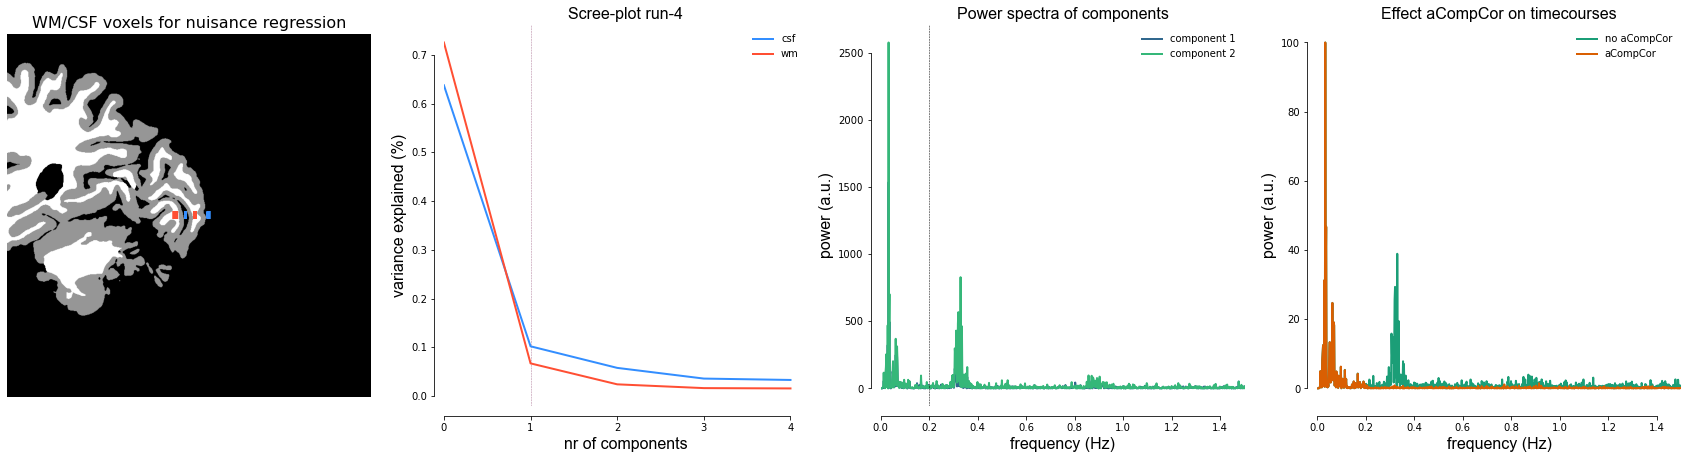

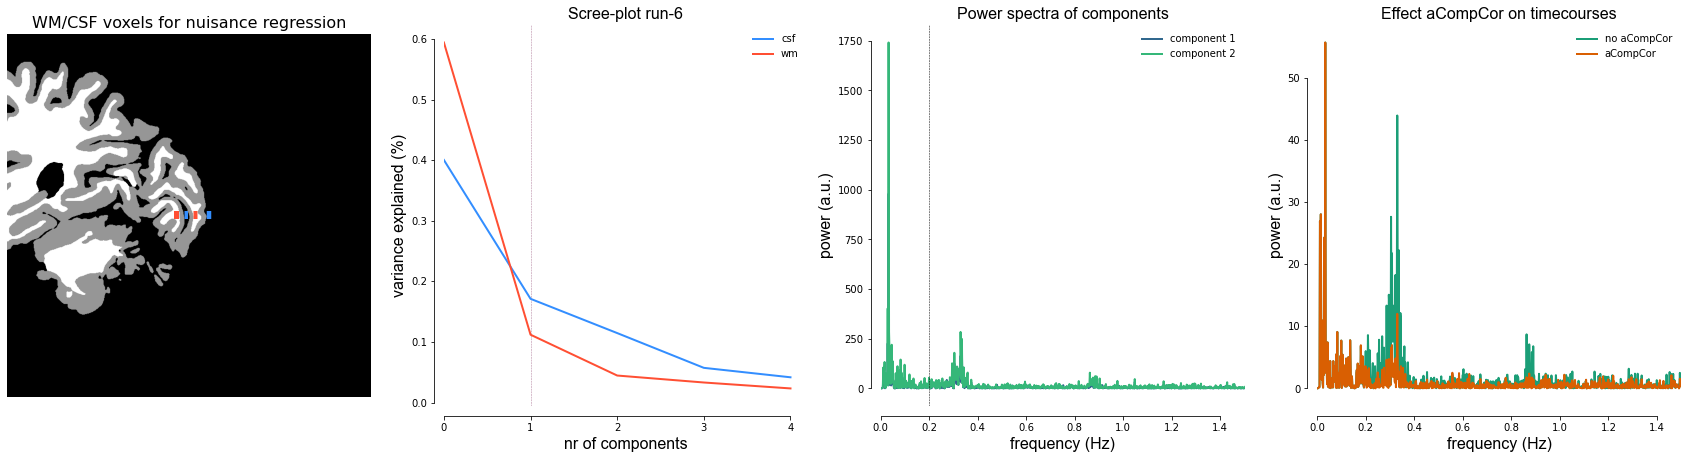

In [44]:
window = 19
order = 3

lp = False

# get FS-to-ses transformation
trafo = utils.get_file_from_substring(f"ses{ses}_rec-motion1", opj(deriv_dir, 'pycortex', f"sub-{sub}", 'transforms'))

# run specific transformation
trafo_run = utils.get_file_from_substring("to-run4", trafo_dir)

# fetch correct reference slice
ref_slice = utils.get_file_from_substring("run-4", ref_slices)
func = utils.get_file_from_substring("run-4", func_file)

# run 4
run4 = dataset.Dataset(func,
                       verbose=True,
                       acompcor=True,
                       ref_slice=ref_slice,
                       ses1_2_ls=trafo,
                       run_2_run=trafo_run,
                       gm_range=[355,375],
                       voxel_cutoff=300,
                       save_as=opj(anat_dir, f"sub-{sub}_ses-{ses}"))

run4_func = run4.fetch_fmri()

# run 6
trafo_run = utils.get_file_from_substring("to-run6", trafo_dir)

# fetch correct reference slice
ref_slice = utils.get_file_from_substring("run-6", ref_slices)
func = utils.get_file_from_substring("run-6", func_file)

run6 = dataset.Dataset(func,
                       verbose=True,
                       acompcor=True,
                       ref_slice=ref_slice,
                       ses1_2_ls=trafo,
                       run_2_run=trafo_run,
                       voxel_cutoff=300,
                       gm_range=[355,375])

run6_func = run6.fetch_fmri()

---
# New voxel-selection strategy

See discussion https://github.com/spinoza-centre/pRFline/issues/13

"_We're mostly interested in a particular patch of cortex consisting of about 6-7 voxels. This can be the case for one run, but the next run can have more voxels due to motion. This makes averaging tricky: which voxels to select? But, this process means we're selecting an ROI a priori. SD suggested to select the ROI later: first, we average the tissue segmentations, and select GM voxels based on a given threshold. This would ensure we're only selecting GM-voxels that are present in both runs. Basically, we select the ROI a posteriorly._"

In [34]:
run4.gm_df.columns


Index(['vox 360', 'vox 361', 'vox 362', 'vox 363'], dtype='object')

In [35]:
run6.gm_df.columns


Index(['vox 361', 'vox 362', 'vox 363', 'vox 364', 'vox 365'], dtype='object')

As we can see, different voxels were selected for different runs. This also means the voxels in each run won't be perfectly aligned. In other words, voxel 382 can be gray matter in one run, and white matter in another. This makes averaging across runs extremely tricky. Ideally, we find a solution that "alignes" the voxels as good as possible. I do this partly already by manually aligning the slices. This particularly helps in selecting WM/CSF voxels

In [54]:
# get the segmentations in beam representation
run4.acomp.segmentations_to_beam()
run6.acomp.segmentations_to_beam()

# shape = (720,16)
ctx1 = run4.acomp.segmentations_in_beam[run4.subject]['cortex']
ctx2 = run6.acomp.segmentations_in_beam[run6.subject]['cortex']


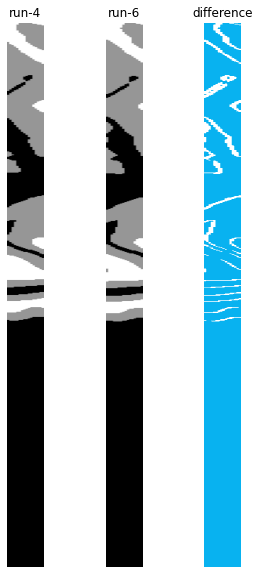

In [55]:
fig = plt.figure(figsize=(5,10))
gs = fig.add_gridspec(1,3)

aspect = 1/3
cmap1 = "Greys_r"
cmap2 = utils.make_binary_cm("#08B2F0")

# cortex beam in run-4
ax1 = fig.add_subplot(gs[0])
ax1.imshow(ctx1, cmap=cmap1, aspect=aspect)
ax1.set_title("run-4")

# cortex beam in run-6
ax2 = fig.add_subplot(gs[1])
ax2.imshow(ctx2, cmap=cmap1, aspect=aspect)
ax2.set_title("run-6")

# difference
ax3 = fig.add_subplot(gs[2])
ax3.imshow((ctx1 == ctx2).astype(int), cmap=cmap2, aspect=aspect)
ax3.set_title('difference')
for ax in ax1,ax2,ax3:
    ax.axis('off')


Average tissue-probability maps

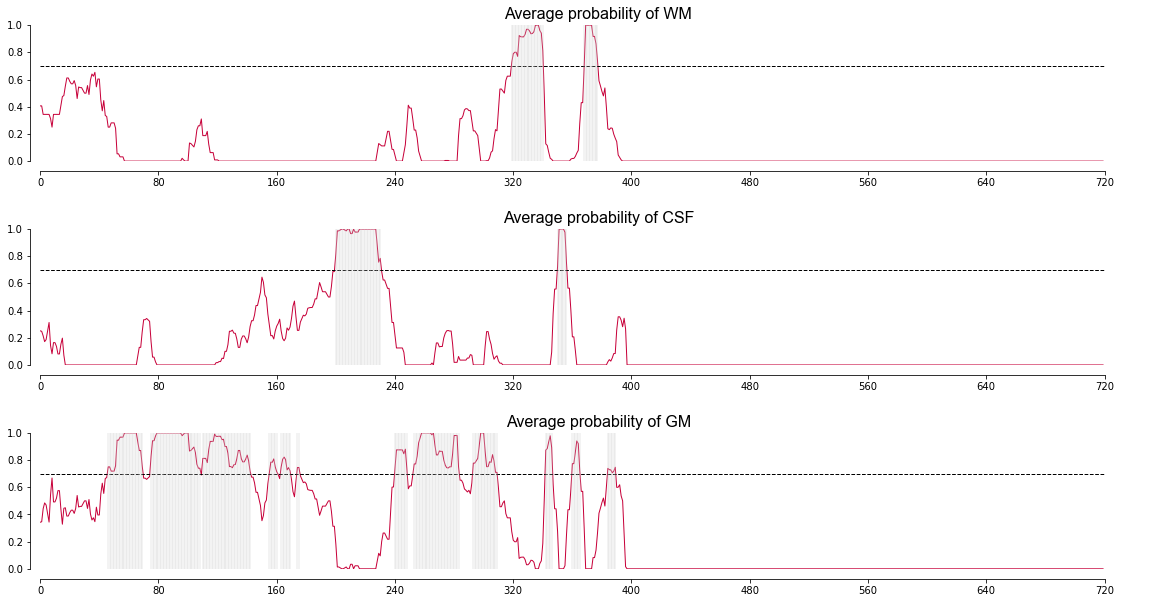

In [57]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(3,1, hspace=0.5)

thresh = 0.7
voxel_classification = {}
for ix, seg in enumerate(['wm', 'csf', 'gm']):
    ax = fig.add_subplot(gs[ix])

    img1 = run4.acomp.segmentations_in_beam[run4.subject][seg][...,np.newaxis]
    img2 = run6.acomp.segmentations_in_beam[run6.subject][seg][...,np.newaxis]
    img  = np.concatenate((img1,img2), axis=-1)
    avg_runs  = img.mean(axis=-1).mean(axis=-1)
    avg_err = sem(avg_runs, axis=-1)

    add_hline = {'pos': thresh, 'color': 'k', 'ls': '--', 'lw': 1}

    plotting.LazyPlot(avg_runs,
                      axs=ax,
                      error=avg_err,
                      title=f'Average probability of {seg.upper()}',
                      font_size=16,
                      y_lim=[0,1],
                      linewidth=2,
                      color="#C70039",
                      sns_trim=True,
                      add_hline=add_hline)

    voxel_classification[seg] = np.where(avg_runs > thresh)[0]
    for ii in voxel_classification[seg]:
        ax.axvline(ii, alpha=0.3, color="#cccccc")


In [129]:
empty_gm = np.zeros((720,720))
beam_gm = np.zeros((720,1))
beam_gm[voxel_classification['gm']] = 1
beam_gm = np.tile(beam_gm.astype(int), 16)
empty_gm[:, 352:368] = beam_gm
# empty_gm = np.rot90(empty_gm)

ref = nb.load(run4.acomp.segmentation_df[run4.subject]['ref'])
nb.Nifti1Image(empty_gm[...,np.newaxis], affine=ref.affine, header=ref.header).to_filename(opj(anat_dir, "gm_beam.nii.gz"))

**PROBLEM**: the fact that we need subject specific slice-to-slice registration files makes the setup not viable for multi-subject preprocessing. I.e., we'd need to create a dataset-object for each subject individually. 

In [20]:
all_data = dataset.DatasetCollector([run4,run6])
all_data.__dict__

Fetching dataframe from attribute 'df_func_zscore'
Fetching dataframe from attribute 'df_func_zscore'


{'datasets': [<linescanning.dataset.Dataset at 0x7f9c12af4e80>,
 'data':                         vox 0     vox 1     vox 2     vox 3     vox 4  \
 subject run t                                                           
 003     4   0.000   -1.478701 -0.823441 -0.339712 -2.144949 -0.633983   
             0.105   -1.850300 -2.341868 -1.680563 -0.298993 -2.655022   
             0.210   -0.819488 -0.864020  0.205462  0.141086 -1.193816   
             0.315   -0.361345 -0.809463  0.030119  0.873969  0.615279   
             0.420    0.652908 -0.818716  0.157862 -0.452812  0.597488   
 ...                       ...       ...       ...       ...       ...   
         6   545.475  0.067419  0.545293  0.045923 -0.535747 -0.308666   
             545.580 -0.964893  0.561656  0.405349 -0.061210  0.112569   
             545.685  0.630711 -1.984092  0.203598 -1.149522 -0.712403   
             545.790  0.497742  0.056417  0.658183 -0.266516 -0.049068   
             545.895  0.553323  0.256740

In [22]:
all_data.data

vox 0     vox 1     vox 2     vox 3     vox 4  \
subject run t                                                           
003     4   0.000   -1.478701 -0.823441 -0.339712 -2.144949 -0.633983   
            0.105   -1.850300 -2.341868 -1.680563 -0.298993 -2.655022   
            0.210   -0.819488 -0.864020  0.205462  0.141086 -1.193816   
            0.315   -0.361345 -0.809463  0.030119  0.873969  0.615279   
            0.420    0.652908 -0.818716  0.157862 -0.452812  0.597488   
...                       ...       ...       ...       ...       ...   
        6   545.475  0.067419  0.545293  0.045923 -0.535747 -0.308666   
            545.580 -0.964893  0.561656  0.405349 -0.061210  0.112569   
            545.685  0.630711 -1.984092  0.203598 -1.149522 -0.712403   
            545.790  0.497742  0.056417  0.658183 -0.266516 -0.049068   
            545.895  0.553323  0.256740  1.329812  0.952423 -0.503303   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
003     4   0.000   -1.405967 -0.706778 -1.003062 -1.007606 -0.882878  ...   
            0.105   -2.863243 -0.388008 -0.773172 -1.750892 -0.941124  ...   
            0.210    0.285656  1.114475  0.006648 -2.793769 -0.392092  ...   
            0.315   -0.084492  0.419576  2.274535 -0.466884 -0.801115  ...   
            0.420   -1.117251  0.849030 -0.438449  1.929674 -0.319811  ...   
...                       ...       ...       ...       ...       ...  ...   
        6   545.475  1.329280 -0.182060  0.643030 -0.803914  1.081724  ...   
            545.580 -0.692928  1.277788  0.061372  3.932287 -1.331945  ...   
            545.685  0.394922 -0.036329  1.081378 -0.617247 -0.756781  ...   
            545.790  0.961440  1.698795 -0.357302  0.230908 -0.457690  ...   
            545.895  1.022272  0.515467 -0.053704 -1.054132  0.158030  ...   

                      vox 710   vox 711   vox 712   vox 713   vox 714  \
subject run t                                                           
003     4   0.000    0.575573 -0.993113 -0.305846  1.285743 -1.349209   
            0.105    0.019138 -1.871627  0.542205 -0.687574 -0.625061   
            0.210    0.385805 -0.943030  1.358508 -0.080199  0.250289   
            0.315   -1.177237 -0.243119 -1.156853  0.517191  0.015214   
            0.420   -0.018131  1.843882 -0.366677 -0.334060 -1.736367   
...                       ...       ...       ...       ...       ...   
        6   545.475  1.018561  0.067908  0.744132 -0.262738 -0.856776   
            545.580 -1.399370 -0.150047  3.408428 -0.024848 -0.853390   
            545.685  1.187563  0.185496  0.602195  0.954194 -0.395624   
            545.790 -0.743037 -0.192856 -0.744504 -0.808212 -0.204630   
            545.895 -0.377160 -0.523045  2.245394  0.697698 -0.858850   

                      vox 715   vox 716   vox 717   vox 718   vox 719  
subject run t                                                          
003     4   0.000   -0.658841  0.659391  0.564813  2.015598 -0.119319  
            0.105    0.826153 -0.102629  0.998209 -1.383315 -0.160840  
            0.210    0.670851 -0.606931  0.475912  0.476858 -0.278205  
            0.315   -1.479244 -0.745639  2.438741 -0.839353  1.619563  
            0.420    0.269586  0.841144  0.218686  1.149237  1.513036  
...                       ...       ...       ...       ...       ...  
        6   545.475 -0.542758  0.382698  1.250748 -0.972330 -0.130932  
            545.580 -0.311357  0.292248 -0.259702 -1.701756 -0.095023  
            545.685  1.797201  0.096230 -0.718588 -0.409108 -0.094833  
            545.790  0.668798 -0.308182  0.409775 -2.046459 -1.222981  
            545.895 -0.291730  1.360065  0.683172  1.451113 -0.954913  

[10400 rows x 720 columns]

In [8]:
# check how concatenation of multiple dataset objects would work

func = pd.concat((run4_func, run6_func))
func

vox 0     vox 1     vox 2     vox 3     vox 4  \
subject run t                                                           
003     4   0.000   -1.478701 -0.823441 -0.339712 -2.144950 -0.633983   
            0.105   -1.850300 -2.341868 -1.680563 -0.298993 -2.655022   
            0.210   -0.819488 -0.864020  0.205462  0.141086 -1.193816   
            0.315   -0.361344 -0.809463  0.030119  0.873969  0.615279   
            0.420    0.652908 -0.818716  0.157862 -0.452812  0.597488   
...                       ...       ...       ...       ...       ...   
        6   545.475  0.067419  0.545293  0.045923 -0.535747 -0.308666   
            545.580 -0.964893  0.561656  0.405349 -0.061210  0.112569   
            545.685  0.630711 -1.984092  0.203598 -1.149522 -0.712402   
            545.790  0.497742  0.056417  0.658183 -0.266516 -0.049068   
            545.895  0.553323  0.256740  1.329812  0.952423 -0.503303   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
003     4   0.000   -1.405967 -0.706778 -1.003062 -1.007607 -0.882878  ...   
            0.105   -2.863243 -0.388008 -0.773172 -1.750892 -0.941124  ...   
            0.210    0.285656  1.114475  0.006648 -2.793769 -0.392091  ...   
            0.315   -0.084492  0.419576  2.274535 -0.466884 -0.801115  ...   
            0.420   -1.117251  0.849030 -0.438449  1.929675 -0.319811  ...   
...                       ...       ...       ...       ...       ...  ...   
        6   545.475  1.329280 -0.182060  0.643031 -0.803914  1.081724  ...   
            545.580 -0.692928  1.277788  0.061372  3.932287 -1.331945  ...   
            545.685  0.394922 -0.036329  1.081378 -0.617247 -0.756781  ...   
            545.790  0.961441  1.698795 -0.357302  0.230908 -0.457690  ...   
            545.895  1.022272  0.515467 -0.053704 -1.054132  0.158030  ...   

                      vox 710   vox 711   vox 712   vox 713   vox 714  \
subject run t                                                           
003     4   0.000    0.575573 -0.993113 -0.305846  1.285743 -1.349209   
            0.105    0.019138 -1.871627  0.542205 -0.687574 -0.625061   
            0.210    0.385805 -0.943030  1.358508 -0.080199  0.250289   
            0.315   -1.177237 -0.243119 -1.156853  0.517191  0.015214   
            0.420   -0.018131  1.843882 -0.366677 -0.334060 -1.736367   
...                       ...       ...       ...       ...       ...   
        6   545.475  1.018561  0.067908  0.744132 -0.262738 -0.856776   
            545.580 -1.399370 -0.150047  3.408428 -0.024848 -0.853390   
            545.685  1.187563  0.185496  0.602195  0.954194 -0.395624   
            545.790 -0.743037 -0.192856 -0.744504 -0.808212 -0.204630   
            545.895 -0.377160 -0.523045  2.245394  0.697698 -0.858850   

                      vox 715   vox 716   vox 717   vox 718   vox 719  
subject run t                                                          
003     4   0.000   -0.658841  0.659391  0.564813  2.015598 -0.119319  
            0.105    0.826153 -0.102629  0.998209 -1.383315 -0.160840  
            0.210    0.670851 -0.606931  0.475912  0.476858 -0.278205  
            0.315   -1.479244 -0.745639  2.438741 -0.839353  1.619563  
            0.420    0.269586  0.841144  0.218686  1.149237  1.513036  
...                       ...       ...       ...       ...       ...  
        6   545.475 -0.542758  0.382698  1.250748 -0.972330 -0.130932  
            545.580 -0.311357  0.292248 -0.259702 -1.701756 -0.095023  
            545.685  1.797201  0.096230 -0.718588 -0.409108 -0.094832  
            545.790  0.668798 -0.308182  0.409775 -2.046459 -1.222981  
            545.895 -0.291730  1.360065  0.683172  1.451113 -0.954913  

[10400 rows x 720 columns]

DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Filtering strategy: 'hp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-4
 Foldover: FH
 Ref slice: /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-4_T1w.nii.gz
 Trafo's: ['/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/pycortex/sub-003/transforms/sub-003_from-ses1_to-ses4_rec-motion1_desc-genaff.mat', '/mnt/d/FSL/shared/spinoza/projects/hemifield/testing/alignment/from-run2_to-run4.txt']
 Found 35 voxel for nuisance regression; (indices<300 are ignored due to distance from coil)
 We're good to go!
 Using 5 components for aCompCor (WM/CSF separately)
 Found 1 component(s) in 'csf'-voxels with total explained variance of 0.64%
 Found 1 componen

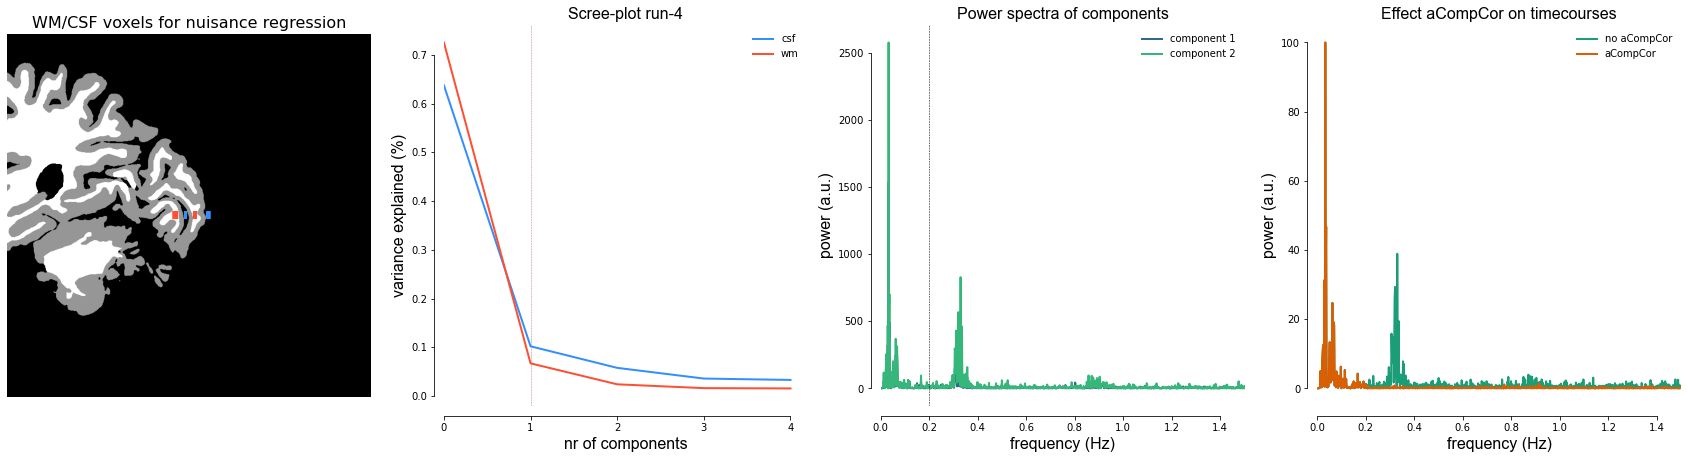

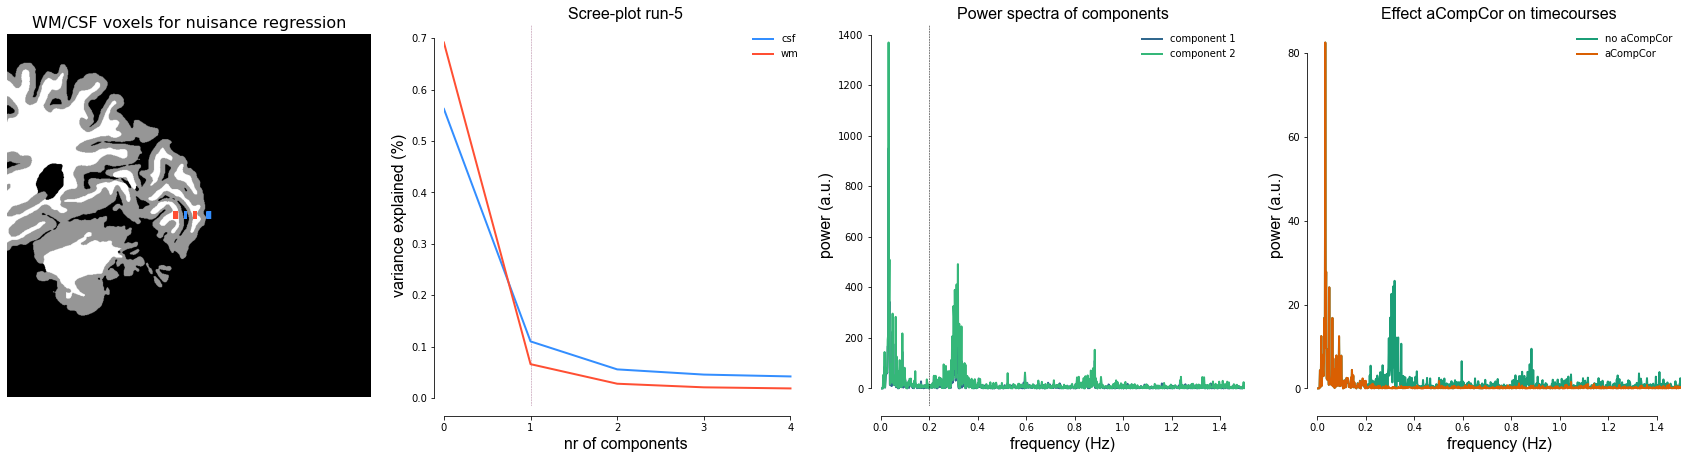

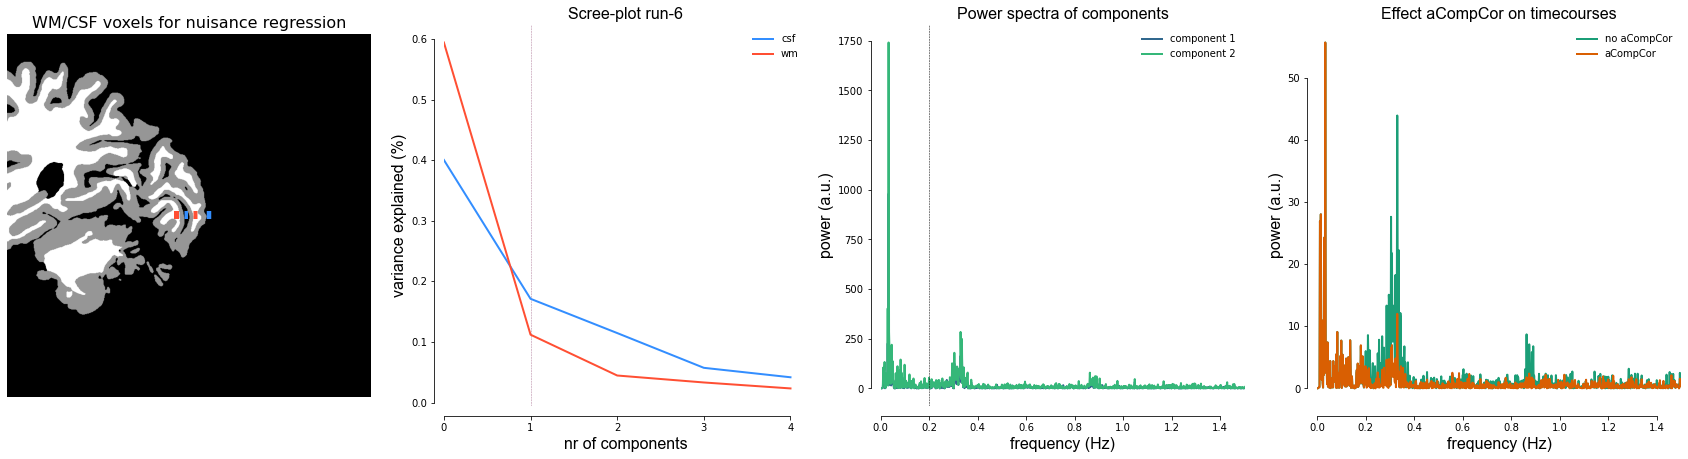

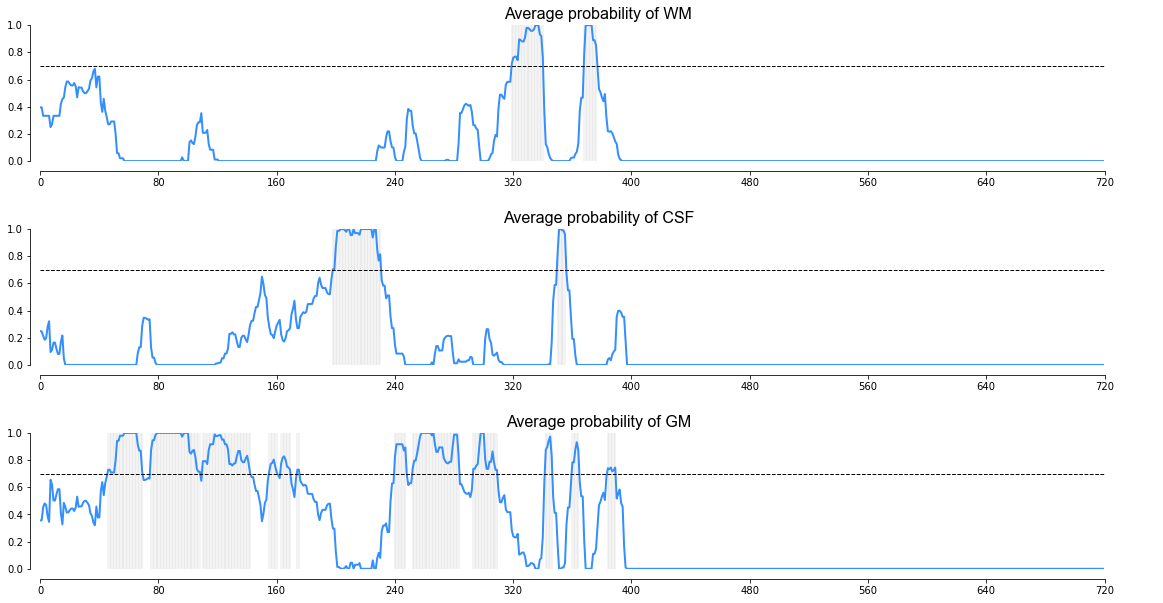

In [78]:
# fetch correct reference slice
ref_slice = utils.get_file_from_substring("run-6", ref_slices)
func = utils.get_file_from_substring("run-6", func_file)
trafo_run = utils.get_file_from_substring("txt", trafo_dir)
trafo_run

data_obj = dataset.Dataset(func_file,
                           verbose=True,
                           acompcor=True,
                           ref_slice=ref_slices,
                           ses1_2_ls=trafo,
                           run_2_run=trafo_run,
                           gm_range=[355,375],
                           voxel_cutoff=300,                           
                           save_as=opj(anat_dir, f"sub-{sub}_ses-{ses}"))

In [79]:
data_obj.ribbon_df

vox 360   vox 361   vox 362   vox 363   vox 364
subject run t                                                        
003     4   0.000    0.218812  0.632630 -1.099871 -0.499439 -0.196424
            0.105   -0.111041 -0.895725 -0.961042 -1.062925 -1.851224
            0.210   -0.739343 -0.154188  0.345755  0.320534  1.280448
            0.315   -1.361529 -1.110578 -1.054330 -0.445821 -0.716879
            0.420    0.038283 -0.463285 -0.527287  0.442701  0.574783
...                       ...       ...       ...       ...       ...
        6   545.475  0.841891  1.563439  1.360963  0.915495  1.002043
            545.580 -0.011968  1.048811  0.473608  1.118479  1.228984
            545.685  1.075451  0.628886  0.193524  0.520241  1.394033
            545.790  1.033361  0.472302  0.073951  0.596255  0.837424
            545.895  0.577606  1.413461  1.439330  2.029501  1.303066

[15600 rows x 5 columns]

In [80]:
voxel_classification

{'wm': array([319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
        332, 333, 334, 335, 336, 337, 338, 339, 340, 368, 369, 370, 371,
        372, 373, 374, 375, 376, 377]),
 'csf': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 350, 351, 352, 353, 354, 355, 356]),
 'gm': array([ 46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 168, 

In [77]:
[ii for ii in range(*data_obj.gm_range) if ii in data_obj.voxel_classification['gm']]


[360, 361, 362, 363, 364]

---
# Aligner

The plot above doesn't tell me too much.. Just that there is some shift, but it's not too clear. Below I collapsed over the last axis to get a line profile for both runs, maybe we can do something similar as in this notebook: https://github.com/spinoza-centre/pRFline/blob/main/notebooks/anat/confirm.ipynb

max correlation = 0.99; padding of 0 voxels


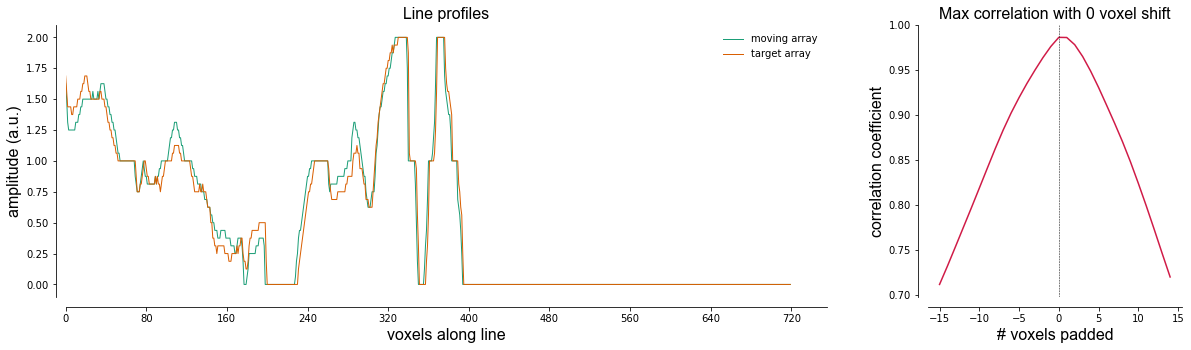

In [19]:
aligner = segmentations.Align(run4.acomp, run6.acomp, verbose=True, save_as=opj(anat_dir, f"sub-{sub}_ses-{ses}_desc-aligner.png"))


What to do in case of mismatch between the runs regarding number of GM-voxels.. Only include those voxels that exist across runs?

In [20]:
print(aligner.moving_gm_voxels)
print(aligner.target_gm_voxels)

[323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 368 369
 370 371 372 373 374 375]
[320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 369 370 371 372 373 374 375 376]


TK: "_One comment - if you’re calculating the correlations across the entire line, this will incorporate signal from irrelevant sections of the brain, and if the brain rotates (usually a yaw movement around an axis near the back of the head) these irrelevant sections will actually move out of the line more than the part we’re aiming for. This might skew your correlation measures and make them less relevant for the patch of gray matter you’re targeting. So perhaps you want to **weigh your correlation** by **vicinity to the center** of the line or something like that._"

Options for weighting:

[] Use brain mask (`run4.segmentation_in_beam[run4.subject]['mask'])`)

[x] Use `CurveFitter` to fit a polynomial to the line-profile; EDIT: even 7th-order polynomial doesn't follow the profile properly

[x] Use skewed Gaussian distribution; EDIT: very annoying to set up properly 

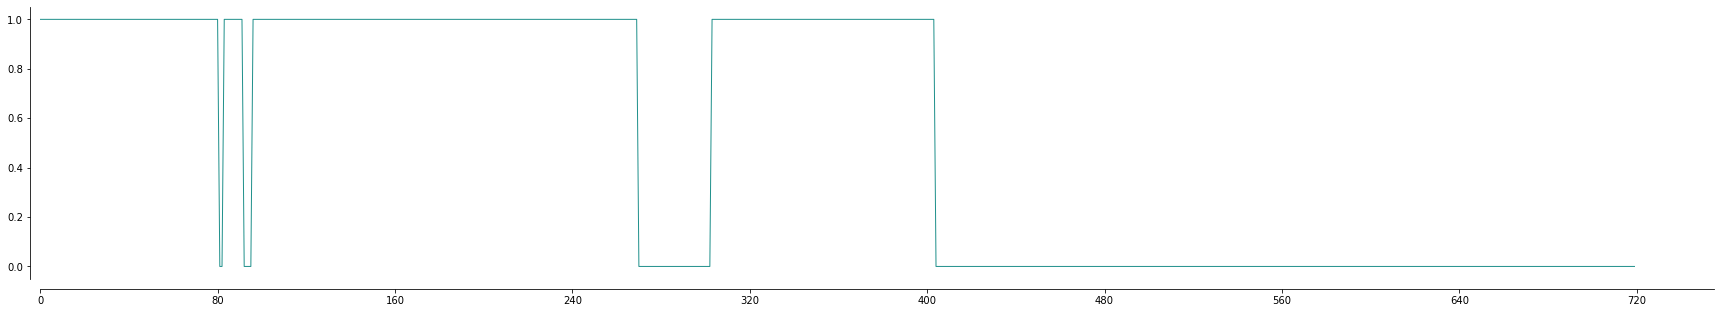

In [22]:
# get (720,16) mask
mask = run4.acomp.segmentations_in_beam[run4.subject]['mask'].mean(axis=-1)

# create empty mask
mask_line = np.zeros_like(mask)

# set values in `mask>0.9` to 1
mask_line[mask>0.9] = 1 
plotting.LazyPlot(mask_line)

In [23]:
do_corr = np.hstack((aligner.moving_cortex_line[...,np.newaxis], aligner.target_cortex_line[...,np.newaxis]))
do_corr.shape


(720, 2)

In [24]:
descr = stats.DescrStatsW(do_corr, weights=mask_line)
descr.corrcoef

array([[1.   , 0.974],
       [0.974, 1.   ]])

In [25]:
np.corrcoef(aligner.moving_cortex_line, aligner.target_cortex_line)

array([[1.   , 0.986],
       [0.986, 1.   ]])

Right, so the correlation changes if we add weights for the brain mask. This is now implemented in `linescanning.Segmentations.get_voxel_shift` in a similar fashion as outlined above. First, let's check if we didn't break anything in the original implementation:

max correlation = 0.99; padding of 0 voxels


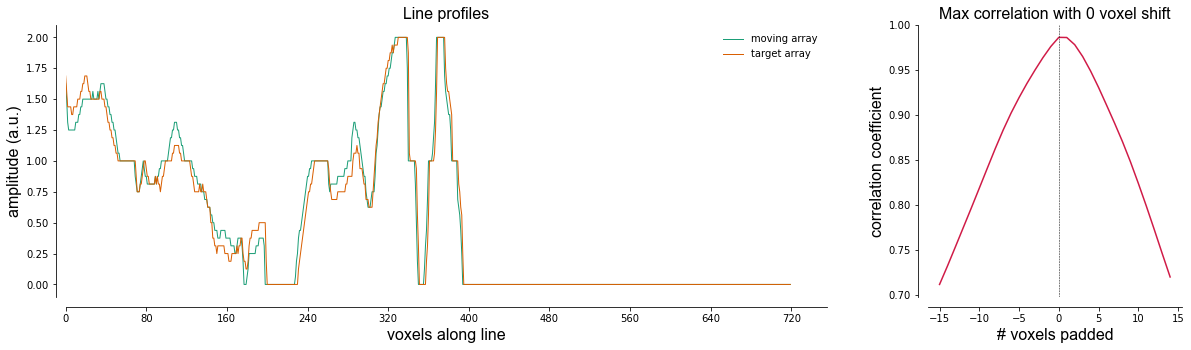

In [26]:
aligner = segmentations.Align(run4.acomp, run6.acomp, verbose=True, save_as=opj(anat_dir, f"sub-{sub}_ses-{ses}_desc-align.png"))


Now let's use the brainmask from the `target` as weights

max correlation = 0.98; padding of 1 voxels


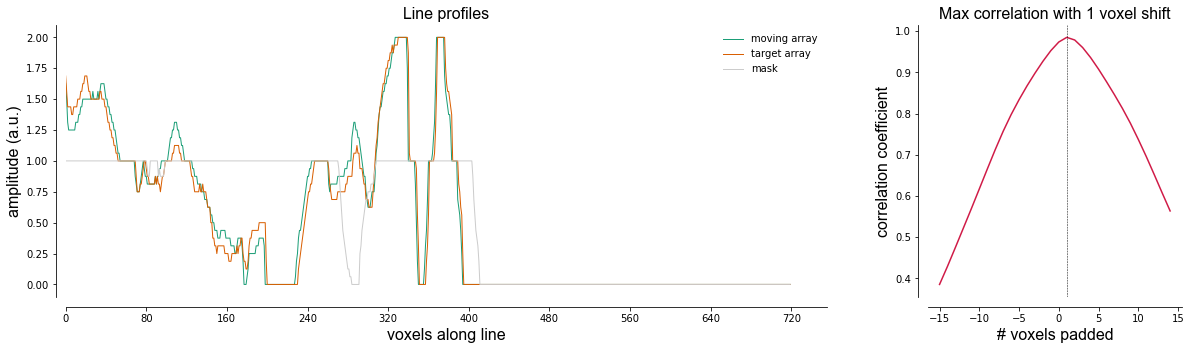

In [27]:
aligner = segmentations.Align(run4.acomp, run6.acomp, verbose=True, weights='target', save_as=opj(
    anat_dir, f"sub-{sub}_ses-{ses}_desc-align.png"))


In [28]:
print(aligner.moving_gm_voxels)
print(aligner.target_gm_voxels)

[323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 368 369
 370 371 372 373 374 375]
[320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 369 370 371 372 373 374 375 376]


In [29]:
print(len(aligner.moving_gm_voxels))
print(len(aligner.target_gm_voxels))

24
29


Add `distance-to-coil`-criteria when selecting WM/CSF voxels

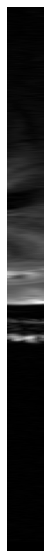

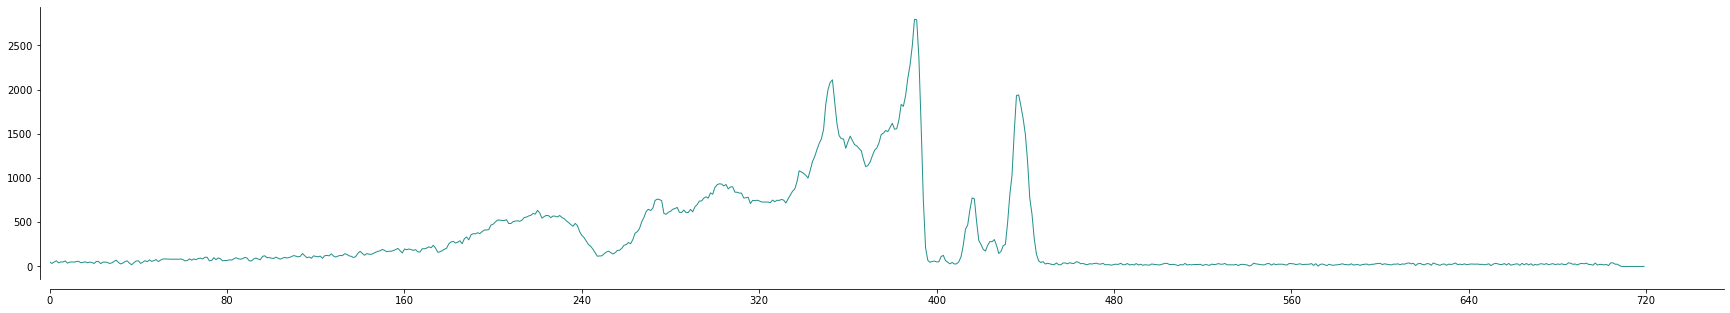

In [35]:
ref1 = run4.acomp.segmentations_in_beam[run4.subject]['ref']

fig,axs = plt.subplots(figsize=(5,10))
axs.imshow(ref1, cmap='Greys_r', aspect=1/3)
axs.axis('off')
plt.show()

plotting.LazyPlot(ref1.mean(axis=1))
